In [2]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

#### Input params ##################
stk_path = '/content/drive/My Drive/VTI (2).csv'
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=1                 # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=1                       # lstm param. initial value before tuning.
batch_size=1                   # lstm param. initial value before tuning.

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(101)
set_random_seed(model_seed)

In [0]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list
  
def train_pred_eval_model(x_train_scaled, \
                            y_train_scaled, \
                            x_cv_scaled, \
                            y_cv, \
                            mu_cv_list, \
                            std_cv_list, \
                            lstm_units=50, \
                            dropout_prob=0.5, \
                            optimizer='adam', \
                            epochs=1, \
                            batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # Calculate RMSE and MAPE
#     print("x_cv_scaled = " + str(x_cv_scaled))
#     print("est_scaled = " + str(est_scaled))
#     print("est = " + str(est))
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

In [6]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2014-06-20,102.199997,102.199997,101.980003,102.169998,92.437279,1952800,6
1,2014-06-23,102.190002,102.250000,101.949997,102.139999,92.410141,1308600,6
2,2014-06-24,101.540001,102.070000,100.910004,101.010002,91.765137,1613400,6
3,2014-06-25,100.820000,101.599998,100.779999,101.519997,92.228447,1379200,6
4,2014-06-26,101.529999,101.529999,100.760002,101.459999,92.173927,1423900,6


Text(0, 0.5, 'USD')

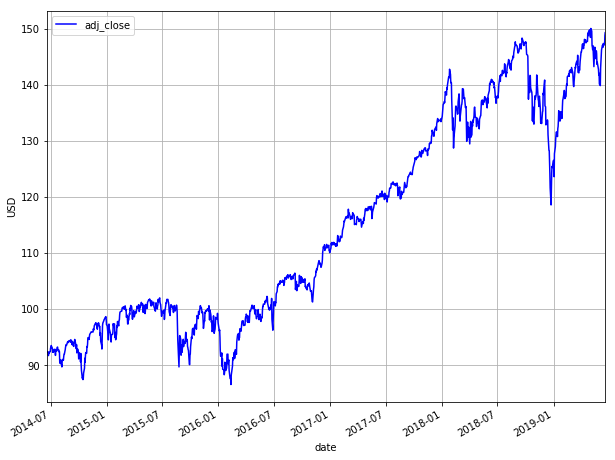

In [7]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [8]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train][['date', 'adj_close']]
cv = df[num_train:num_train+num_cv][['date', 'adj_close']]
train_cv = df[:num_train+num_cv][['date', 'adj_close']]
test = df[num_train+num_cv:][['date', 'adj_close']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 756
num_cv = 251
num_test = 251
train.shape = (756, 2)
cv.shape = (251, 2)
train_cv.shape = (1007, 2)
test.shape = (251, 2)


In [9]:

# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['adj_close']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) # (446, 7, 1)
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) # (446, 1)

scaler.mean_ = [101.21622004]
scaler.var_ = [62.88053818]
x_train_scaled.shape = (747, 9, 1)
y_train_scaled.shape = (747, 1)


In [10]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (251, 9, 1)
y_cv.shape = (251, 1)
len(mu_cv_list) = 251
len(std_cv_list) = 251


In [11]:
# Here we scale the train_cv set, for the final model
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['adj_close']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# # Scale the test dataset
# x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['adj_close']).reshape(-1,1), N, num_train+num_cv)
# print("x_test_scaled.shape = " + str(x_test_scaled.shape))
# print("y_test.shape = " + str(y_test.shape))
# print("len(mu_test_list) = " + str(len(mu_test_list)))
# print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [108.50733515]
scaler_final.var_ = [218.05685917]


In [12]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

W0629 17:43:44.958116 140360077080448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0629 17:43:44.964870 140360077080448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 17:43:44.974464 140360077080448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0629 17:43:45.403621 140360077080448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0629 17:43:45.646021 140360077080448 deprecation.py:323

Epoch 1/1
 - 24s - loss: 0.0640


In [13]:

# Print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


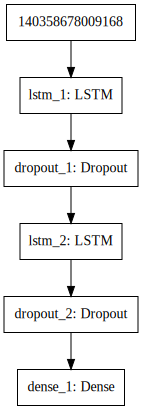

In [14]:

# Plot model and save to file
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model_v4a.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [15]:
# Do prediction
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("est.shape = " + str(est.shape))

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

est.shape = (251, 1)
RMSE = 1.679
MAPE = 0.865%


Text(0, 0.5, 'USD')

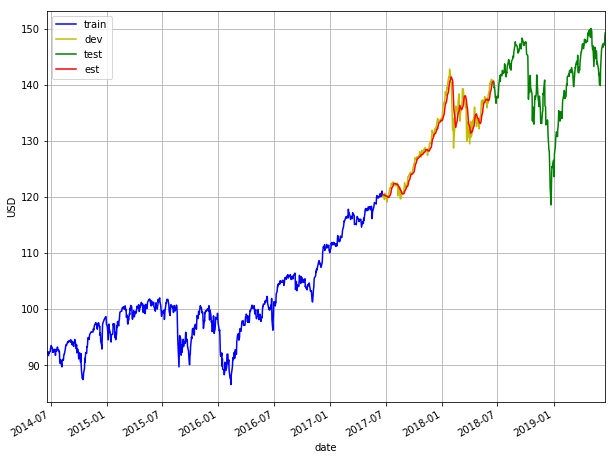

In [17]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'y_cv': y_cv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [18]:
param_label = 'N'
param_list = range(3, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # Split cv into x and y
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1,1), param, num_train)
    
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer=optimizer, \
                                          epochs=epochs, \
                                          batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 67.12861786286037


,N,rmse,mape_pct
0,3,1.330008,0.696592
1,4,1.411793,0.742633
2,5,1.496073,0.776360
3,6,1.570583,0.801540
4,7,1.646904,0.844555
5,8,1.644357,0.846612
6,9,1.638690,0.851435
7,10,1.620186,0.845541
8,11,1.712938,0.895665
9,12,1.562724,0.813728


Text(0, 0.5, 'RMSE/MAPE(%)')

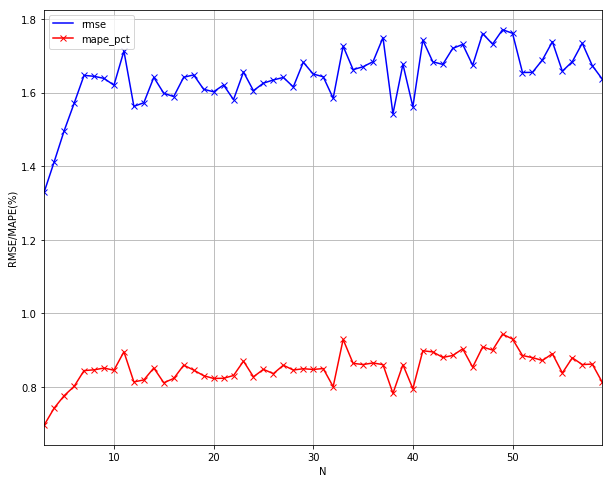

In [19]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [20]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 1.330
min MAPE = 0.697%
optimum N = 3


In [21]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['adj_close']).reshape(-1,1), N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=lstm_units, \
                                              dropout_prob=dropout_prob, \
                                              optimizer=optimizer, \
                                              epochs=param, \
                                              batch_size=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 22.751446056365968


,epochs,batch_size,rmse,mape_pct
0,1,8,1.354006,0.706532
1,1,16,1.368226,0.722062
2,1,32,1.234031,0.637500
3,1,64,1.204996,0.625086
4,1,128,1.197701,0.622350
5,10,8,1.249692,0.647531
6,10,16,1.297675,0.676089
7,10,32,1.329593,0.694236
8,10,64,1.341902,0.701290
9,10,128,1.334759,0.706169


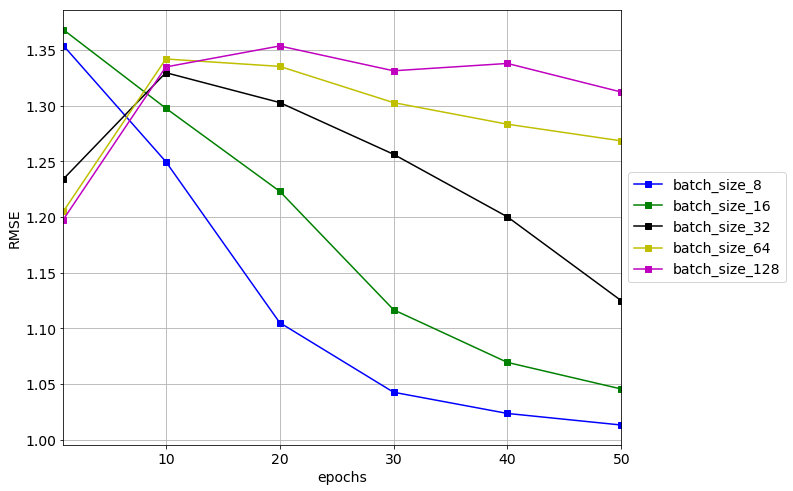

In [23]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [25]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 1.013
min MAPE = 0.502%
optimum epochs = 50
optimum batch_size = 8


In [26]:
param_label = 'lstm_units'
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=param, \
                                              dropout_prob=param2, \
                                              optimizer=optimizer, \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

W0629 19:35:35.834301 140360077080448 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0629 19:37:23.580436 140360077080448 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0629 19:37:23.771624 140360077080448 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0629 19:39:10.948620 140360077080448 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0629 19:39:11.138236 140360077080448 nn_op


Minutes taken = 44.381643803914386


,lstm_units,dropout_prob,rmse,mape_pct
0,10,0.5,1.278995,0.663610
1,10,0.6,1.280025,0.664570
2,10,0.7,1.296221,0.672902
3,10,0.8,1.289161,0.668521
4,10,0.9,1.265285,0.656884
5,10,1.0,1.062635,0.527609
6,50,0.5,1.098317,0.562667
7,50,0.6,1.166818,0.601894
8,50,0.7,1.235665,0.640995
9,50,0.8,1.278849,0.664115


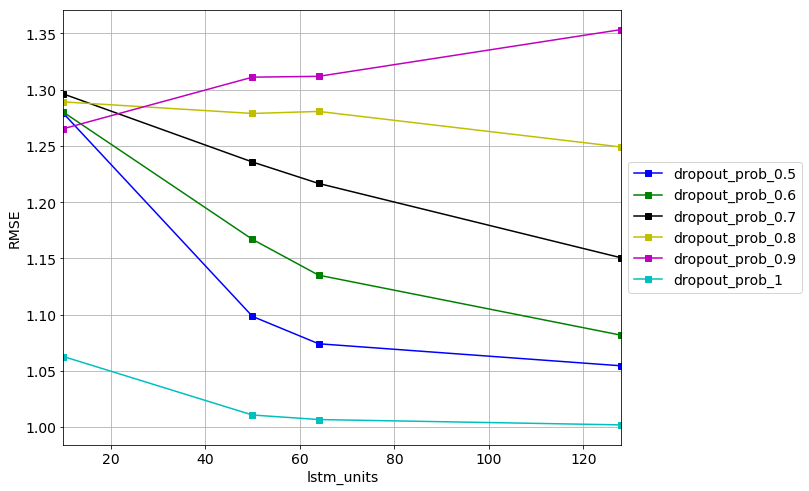

In [27]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [28]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

min RMSE = 1.002
min MAPE = 0.499%
optimum lstm_units = 128
optimum dropout_prob = 1.0


In [29]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
   
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units_opt, \
                                          dropout_prob=dropout_prob_opt, \
                                          optimizer=param, \
                                          epochs=epochs_opt, \
                                          batch_size=batch_size_opt)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 13.554366405804952


,optimizer,rmse,mape_pct
0,adam,1.000956,0.502184
1,sgd,1.254858,0.650803
2,rmsprop,0.997956,0.500278
3,adagrad,1.028071,0.509452
4,adadelta,1.023958,0.503109
5,adamax,1.005185,0.498797
6,nadam,0.996166,0.495852


Text(0, 0.5, 'RMSE/MAPE(%)')

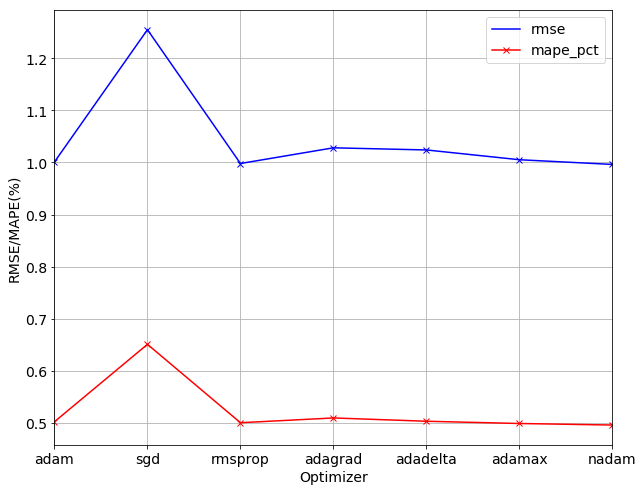

In [30]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [31]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

min RMSE = 0.996
min MAPE = 0.496%
optimum optimizer = nadam


In [32]:

d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,N,9,3
1,lstm_units,50,128
2,dropout_prob,1,1
3,optimizer,adam,nadam
4,epochs,1,50
5,batch_size,1,8
6,rmse,1.67901,0.996166
7,mape_pct,0.865269,0.495852


In [33]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['adj_close']).reshape(-1,1), N_opt, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list, \
                                        lstm_units=lstm_units_opt, \
                                        dropout_prob=dropout_prob_opt, \
                                        optimizer=optimizer_opt, \
                                        epochs=epochs_opt, \
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 1.359
MAPE on test set = 0.694%


Text(0, 0.5, 'USD')

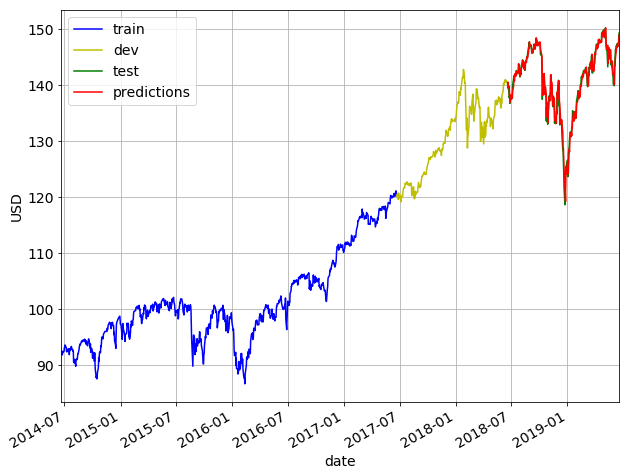

In [34]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

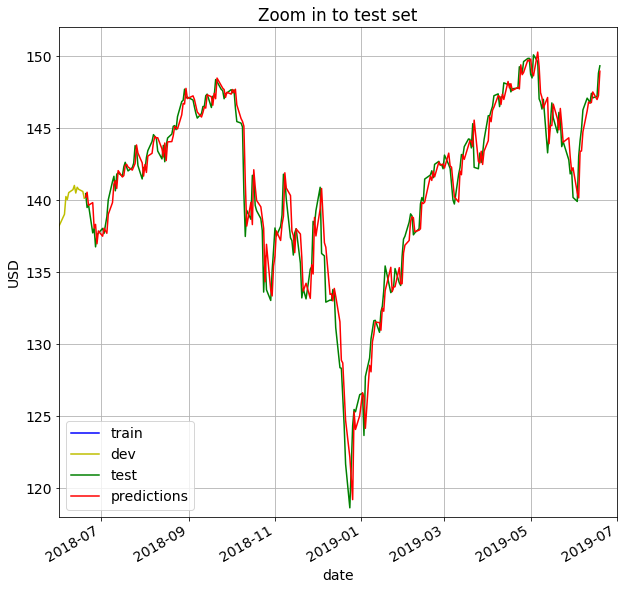

In [41]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 10 # width 10, height 10
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 6, 1), date(2019, 7, 1)])
ax.set_ylim([118, 152])
ax.set_title("Zoom in to test set")

(118, 152)

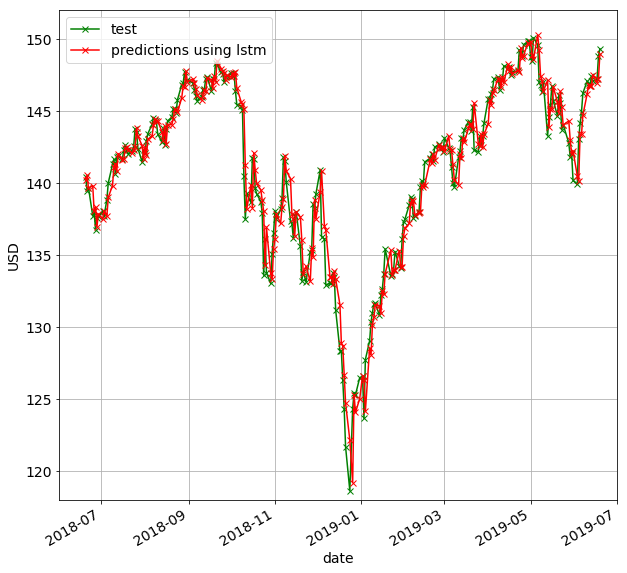

In [44]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 10 # width 10, height 10
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lstm'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 6, 1), date(2019, 7, 1)])
ax.set_ylim([118, 152])